In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.core.debugger import Pdb
from IPython.display import display, clear_output

from QNetwork import neuralnetwork_regression as nn
from GameEngine import multiplayer
from QTable import qtsnake

Point = namedtuple('Point', 'x, y')

pygame 2.5.1 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Representing Q-function using Neural Networks

In the last notebook, I represented my Q-function in a simple lookup table. This notebook offers a difference approach by using a neural network. The function we want the neural network to learn is, of course, the snake's Q-function, which maps a state-action pair onto an expected reward.

#### Benefits of a Q-network

The distinction between a Q-table and Q-network is that a Q-network contains and updates a set of parameters (weights) which summarize previously seen data. A Q-table cannot do this, and thus is completely clueless in situations where it recieves an input it has either not seen, or has not been trained on. In theory, this allows a neural network to not only represent environments with many more states, but also the ability to make guesses about in 'gaps' in its learning.

This notebook will go over training of a simple q-network, which maps a total of 32 different combinations of states and actions onto rewards, much like the previous q-table implementation from ***one_revised_snake_q_table.ipynb***.

First, I will set up the game environment:

In [2]:
# defines game window size and block size, in pixels
WINDOW_WIDTH = 480
WINDOW_HEIGHT = 320
GAME_UNITS = 80

In [3]:
game_engine = multiplayer.Playfield(window_width=WINDOW_WIDTH,
                                    window_height=WINDOW_HEIGHT,
                                    units=GAME_UNITS,
                                    g_speed=35,
                                    s_size=1)

In [4]:
p1 = game_engine.add_player()
game_engine.start_game()
p1

Game starting with 1 players.


0

Training thousands of steps is a little bit slow with the graphics on. It makes only a small difference here, but it provides little information anyways. So, I introduced a function to turn the drawing off.

In [5]:
game_engine.toggle_draw()

Draw is now False.


### State-sensing methods, defining reinforcement and greedy-action selector

I have also imported the aforementioned q_table implementation as qtsnake. It will come back in the end of the notebook when I pair the q_table and q_network against each other, but to make the game fair, I'll use the exact same state-sensing method:

In [6]:
qtsnake.sense_goal

<function QTable.qtsnake.sense_goal(head, goal)>

Even though I plan to only call it when selecting a greedy_action, I'll wrap it in a neat 'query_state' function:

In [7]:
def query_state(id):
    '''
    given a player's id,
    returns their state
    '''
    heads, _, goal = game_engine.get_heads_tails_and_goal()
    return np.array(qtsnake.sense_goal(heads[id], goal))

And now the reinforcement function. Because I took the requirement to sense danger away, we only need two outputs from the reinforcement function. In almost every case, the snake is not allowed to choose an action that would collide with its own tail.

The output of this function was chosen due to being the best-performing. In reality, the reinforcement for non-goals will never be used. I prefer the simplicity of using the discount factor to force agents to the goal quickly. This is because, with larger discount, the snake prioritizes actions that result in more immediate rewards. An alternative approach which a tried is to punish the agent for each unneccessary step.

In [8]:
def reinforcement(outcome):
    '''
    given an outcome of an action,
    returns associated reward
    '''
    if outcome == multiplayer.CollisionType.GOAL:
        return -3
    return 0

For this version of the epsilon greedy function, I wanted an interface similar to the ***one_revised_snake_q_table.ipynb*** notebook. The function operates in the same way, by accumulating the expected reward for each action taken in a state into a list, and then returning the argmin of those actions. I return the expected reward for this action in addition, because it is needed later for learning with discounted rewards.

In [9]:
def pick_greedy_action(q_net, id, epsilon):
    '''
    given a q network, the id of the player
    taking action, and a randomization factor,
    returns the most rewarding non-lethal action
    or a non-lethal random action and expected reward
    '''
    viable_actions = game_engine.get_viable_actions(id)
    state = query_state(id)

    if viable_actions.size < 1:
        best_action = 0
    elif np.random.uniform() < epsilon:
        best_action = np.random.choice(viable_actions)
    else:
        qs = [q_net.use(np.hstack(
            (state, action)).reshape((1, -1))) for action in viable_actions]
        best_action = viable_actions[np.argmin(qs)]

    X = np.hstack((state, best_action))
    q = q_net.use(X.reshape((1, -1)))

    return X, q

### Q-Learning with Temporal Difference, One Sample at a Time

Unlike the marble implementation, I have created a similar training loop to what was observed in the q-table, without the use of a make samples function. This means I adjust each weight for a single sample at a time (batch size 1), assigning the output of each intermediate step to the discounted rewards of future steps, 'bootstrapping' the learning process similar to the temporal difference equation. Remember, the nature of this method is somewhat recursive, as it updates Q to agree with max(Q'), which in turn is updated to agree with max(Q'')...

In [10]:
def update_q(q, old_X, new_X, new_q, outcome, n_epochs, discount=0.9, lr=0.2):
    '''
    given a q network, the previous state/action pair,
    the new state/action pair, the expected next reward,
    the outcome of the last action, the number of epochs,
    a discount factor (gamma), and the learning rate
    updates q with discounted rewards.
    '''
    reward = reinforcement(outcome)
    if outcome == multiplayer.CollisionType.GOAL:
        q.train(np.array([new_X]),
                np.array([reward]) + np.array([[reward]]),
                n_epochs, lr, method='sgd', verbose=False)
    else:
        q.train(np.array([old_X]),
                discount * np.array([new_q]), n_epochs,
                lr, method='sgd', verbose=False)

#### Training

In this case, I already know our game world is limited to 32 inputs. In this minimal case, I don't neccessarily care if the network is generalizable, so there is no real need for a test set, and no real downside of overfitting. My learning process will simply run the experiment for a set amount of steps. This is not to say that my approach may not be generalizable, but that there is no real way to know.

Through use of my exploration strategy, as well as a randomly initialized set of weights, the data passed into the neural network should thouroughly account for all possible inputs.

To start, I initialize a few hyperparameters, discovered largely through trial-and-error, and create a new Q-network object:

In [11]:
gamma = 0.9
n_epochs = 10
learning_rate = 0.015

hidden_layers = [10]
q = nn.NeuralNetwork(2, hidden_layers, 1)
q.setup_standardization([5, 3.5], [4, np.sqrt(5.25)], [-.1], [0.2])

Reminder that gamma is the discount factor, and learning rate controls how quickly the weights are adjusted, much like I used it for the temporal difference equation.

In general, the number of epochs corresponds to the amount of weight updates occur per batch of samples. Often, large numbers result in poor generalizability, which, as mentioned, is not a priority due to the size of the Q-input pool.

Similarly to before, I'll set up epsilon to decay exponentially over a 10,000 step training loop...

In [12]:
n_steps = 10000
epsilon = 1
final_epsilon = 0.05
epsilon_decay =  np.exp(np.log(final_epsilon) / (n_steps))
epsilon_trace = np.zeros(n_steps)

And create a few classes and methods to plot the results:

In [13]:
class Scoreboard():
    ''' tracks game statistics '''
    def __init__(self):
        self.all_goals = 0
        self._deaths = 0
        self._goals = 0
        self._max_goals = 0

        self.goals = []
        self.deaths = []
        self.max_goals = []

    def track_outcome(self, outcome):
        if outcome == multiplayer.CollisionType.GOAL:
            self._goals += 1
            self.all_goals += 1
            if self._goals > self._max_goals:
                self._max_goals = self._goals
        elif outcome == multiplayer.CollisionType.DEATH:
            self._deaths += 1
            self._goals = 0

    def flush(self):
        self.goals.append(self._goals)
        self.deaths.append(self._deaths)
        self.max_goals.append(self._max_goals)

        self._reset()

    def _reset(self):
        self._deaths = 0
        self._goals = 0
        self._max_goals = 0

In [14]:
def plot_status(q, step, epsilon_trace, r_trace=None):
    
    plt.subplot(4, 3, 1)
    plt.plot(epsilon_trace[:step + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)

    plt.subplot(4, 3, 2)
    plt.plot(scoreboard.deaths)
    plt.ylabel('Deaths')

    plt.subplot(4, 3, 3)
    plt.plot(scoreboard.goals)
    plt.ylabel('Goals')

    plt.subplot(4, 3, 4)
    plt.plot(scoreboard.max_goals)
    plt.ylabel('Max Score')

    '''
    plt.subplot(4, 3, 5)
    plt.plot(r_trace[:step + 1], alpha=0.5)
    binSize = 20
    if step+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(r_trace[:int(step / binSize) * binSize].reshape((int(step / binSize), binSize)), axis=1)
        plt.plot(np.arange(1, 1 + int(step / binSize)) * binSize, smoothed)
    plt.ylabel('Mean reinforcement')
    '''

    plt.subplot(4, 3, 6)
    q.draw(['$o$', '$a$'], ['q'])

    plt.tight_layout()

The logic behind this the training loop is the same as the q-table implementation with added calls to the scoreboard and plotting functions, because I took the time to make each function interface the same. If exported this code to a file, I may utilize higher-order functions to allow easy selection of either Q-function:

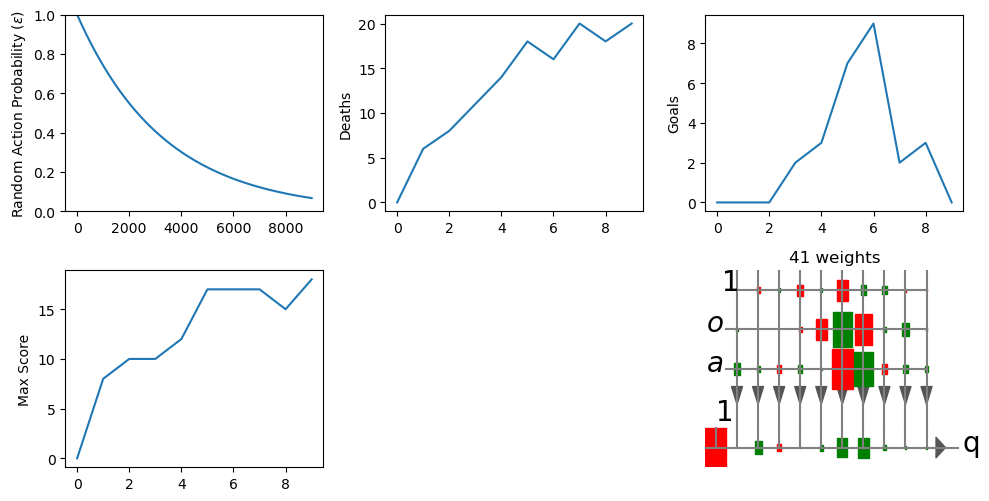

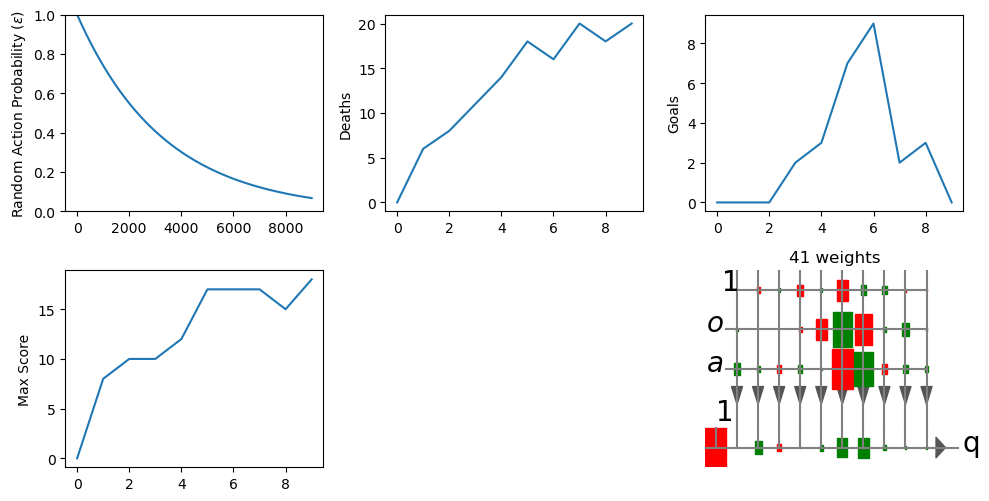

In [15]:
old_X, old_q = pick_greedy_action(q, p1, epsilon)
game_engine.player_advance([old_X[1]])

fig = plt.figure(figsize=(10, 10))
scoreboard = Scoreboard()
plot_spacing = 1000
plotted_steps = 0

# R = np.zeros((plot_spacing, 1))
# r_trace = np.zeros(n_steps // plot_spacing)

for step in range(n_steps):
    new_X, new_q = pick_greedy_action(q, p1, epsilon)
    outcomes = game_engine.player_advance([new_X[1]])
    scoreboard.track_outcome(outcomes[p1])

    update_q(q, old_X, new_X, new_q, outcomes[p1], n_epochs, lr=learning_rate)

    epsilon *= epsilon_decay
    epsilon_trace[step] = epsilon
    # R[step % plot_spacing, 0] = reinforcement(outcomes[p1])
    old_X = new_X
    old_q = new_q

    if step >= plotted_steps:
        # r_trace[plotted_steps // plot_spacing] = np.mean(R)
        plotted_steps += plot_spacing
        scoreboard.flush()
        fig.clf()
        plot_status(q, step, epsilon_trace)
        scoreboard.all_goals = 0
        clear_output(wait=True)
        display(fig)

Like the q-table, the training process occasionally produces a bad agent. This is always due to the agent's exploration finding relatively few goals. To solve this, I specifically select a small envirnoment to train on, as random actions happen to score goals more likely. A slower decay of epsilon would likely improve this further, though this is generally not an issue.

#### Viewing the Results: Multiplayer Snake

Now, I'll test the performance of the Q-network first by itself, in a simple get action advance loop. I'll turn on the draw feature:

In [16]:
game_engine.toggle_draw()

Draw is now True.


In [17]:
epsilon = 0
for step in range(500):
    new_X, _ = pick_greedy_action(q, p1, epsilon)
    game_engine.player_advance([new_X[1]])

If the agent gets stuck, you may want to retrain the agent by running the last few cells.

Now for the fun part: Facing the agents off against each other...

In [18]:
inferior_table = qtsnake.load_q('inferior_qt.npy')
superior_table = qtsnake.load_q('superior_qt.npy')

In [19]:
epsilon = 0
n_steps = 1500

I also make the game really large, to allow the snakes their own space:

In [20]:
game_engine = multiplayer.Playfield(window_width=WINDOW_WIDTH,
                                    window_height=WINDOW_HEIGHT,
                                    units=10,
                                    g_speed=100,
                                    s_size=1)
t1 = game_engine.add_player()
t2 = game_engine.add_player()
n1 = game_engine.add_player()
game_engine.start_game()

Game starting with 3 players.


And initialize a new q-table object with the table. This object is quite nice, because it is not tied to any one q-table; it simply reads and writes a given q-table:

In [21]:
q_table = qtsnake.QSnake(game_engine)

In [22]:
for step in range(n_steps):
    # table 1 (YELLOW)
    _, t1_action = q_table.pick_greedy_action(inferior_table, t1, epsilon)

    # table 2 (RED)
    _, t2_action = q_table.pick_greedy_action(superior_table, t2, epsilon)

    # network 1 (PURPLE)
    n1_state_action, _ = pick_greedy_action(q, n1, epsilon)
    game_engine.player_advance([t1_action,
                                t2_action,
                                n1_state_action[1]])

YELLOW: Learned Q-Table

RED:    Set Q-Table

PURPLE: Learned Q-Network

Often in my games, the q-network finishes second behind the superior, manually set q-table. Sometimes, it is the other way around, dependent on how successful each agent trained, and the luck of goal spawns during the trial. I have also seen it finish first on many occasions. All in all, it seems both the Q-network and Q-table are relatively equally matched in this game representation.

![Q-Network finishes first!](./extras/2023-12-13_17-35.png)